In [1]:
from tensorflow.keras import datasets, layers, models

import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
def padImage(image, pixels=5, pad_sides=True):
    bottom = image[-pixels:]
    top = image[:pixels]

    img = np.insert(image, 0, bottom, 0)
    img = np.insert(img, len(img), top, 0)
    if pad_sides:
        img = np.insert(img, [0], [0] * pixels, 1)
        img = np.insert(img, [-1], [0] * pixels, 1)
    return img

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = (train_images / 255.0).astype(np.float32), test_images.astype(np.float32) / 255.0

In [4]:
### THE PAD HAS TO BE DONE IN THE
### POLAR SPACE

# 20 is the ceiling of (14 * sqrt(2))
X_train_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in train_images]
X_train_polar = [padImage(x, pixels=5) for x in X_train_polar]
X_train_polar = np.array(X_train_polar)[...,None]

X_test_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in test_images]
X_test_polar = [padImage(x, pixels=5) for x in X_test_polar]
X_test_polar = np.array(X_test_polar)[...,None]

# Rotate test set
X_test_r_polar = [tfa.image.rotate(x, np.random.uniform(-np.pi/2., np.pi/2.)).numpy() for x in test_images]
X_test_r_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in X_test_r_polar]
X_test_r_polar = [padImage(x, pixels=5) for x in X_test_r_polar]
X_test_r_polar = np.array(X_test_r_polar)[...,None]

In [26]:
model = models.Sequential()
model.add(layers.Input(shape=X_train_polar.shape[1:]))
model.add(layers.Conv2D(32, (3, 3), activation='relu', strides=1))
model.add(layers.MaxPooling2D())
model.add(layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu', strides=1))
model.add(layers.MaxPooling2D())
model.add(layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu', strides=1))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='linear'))

In [27]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train_polar, train_labels, batch_size=32, epochs=10, 
          validation_data=(X_test_r_polar, test_labels),
          callbacks=[reduce_lr])

Epoch 1/10
1875/1875 [==============================] - 65s 35ms/step - loss: 0.8354 - accuracy: 0.7229 - val_loss: 0.5150 - val_accuracy: 0.8574
Epoch 2/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.1639 - accuracy: 0.9498 - val_loss: 0.4839 - val_accuracy: 0.8645
Epoch 3/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.1235 - accuracy: 0.9617 - val_loss: 0.5228 - val_accuracy: 0.8585
Epoch 4/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.1068 - accuracy: 0.9667 - val_loss: 0.4746 - val_accuracy: 0.8588
Epoch 5/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.1017 - accuracy: 0.9687 - val_loss: 0.4618 - val_accuracy: 0.8595
Epoch 6/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0946 - accuracy: 0.9709 - val_loss: 0.5130 - val_accuracy: 0.8532
Epoch 7/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0828 - accuracy: 0.9738 - val_loss: 0.4828 -

In [28]:
# Plain accuracy
accuracy = np.mean(model.predict(X_test_polar).argmax(axis=1) == test_labels)*100
# "Rotated" accuracy
accuracy_rotated = np.mean(model.predict(X_test_r_polar).argmax(axis=1) == test_labels)*100

print(accuracy, accuracy_rotated)

98.64 86.48


In [42]:
import matplotlib.pyplot as plt
from PIL import Image

In [40]:
fig = plt.Figure(figsize=(10,10))
plt.figure(figsize=(10,10))
rows = 4
cols = 3
a = [0, np.pi/2, np.pi, np.pi/2+np.pi]
img_4 = np.where(train_labels == 4)[0][0]
bgr_cat = cat[:,:,[2,1,0]]
for i in range(4):
    col3 = ((i+1)*cols)
    col2 = col3-1
    col1 = col2-1
    
    rot_img_4 = tfa.image.rotate(bgr_cat, a[i]).numpy()
    #cv.imwrite(f'cat_{i}.png', (rot_img_4 * 255).astype(np.int64))
    max_r = np.sqrt(np.sum((np.array(rot_img_4.shape)[:-1])**2))/2 - 46
    pol_img_4 = cv.linearPolar(rot_img_4, tuple(np.array(rot_img_4.shape)/2)[:-1], max_r, cv.WARP_FILL_OUTLIERS)  
    #cv.imwrite(f'cat_polar_{i}.png', (pol_img_4 * 255).astype(np.int64))
    pol_pad_img_4 = padImage(pol_img_4, pixels=120, pad_sides=False)
    #cv.imwrite(f'cat_polNpad_{i}.png', (pol_pad_img_4 * 255).astype(np.int64))
    
    
    # Normal
    plt.subplot(rows,cols,col1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(rot_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[img_4]))
    # Polar
    plt.subplot(rows,cols,col2)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
    # Polar & Pad
    plt.subplot(rows,cols,col3)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_pad_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
plt.show()

NameError: name 'cat' is not defined

<Figure size 720x720 with 0 Axes>

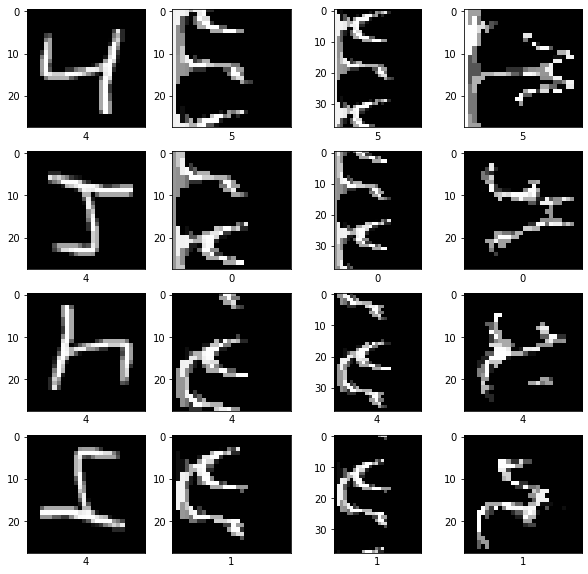

In [44]:
fig = plt.Figure(figsize=(10,10))
plt.figure(figsize=(10,10))
rows = 4
cols = 4
a = [0, np.pi/2, np.pi, np.pi/2+np.pi]
img_4 = np.where(train_labels == 4)[0][0]

for i in range(4):
    col4 = ((i+1)*cols)
    col3 = col4-1
    col2 = col3-1
    col1 = col2-1
    
    rot_img_4 = tfa.image.rotate(train_images[img_4], a[i]).numpy()
    pol_img_4 = cv.linearPolar(rot_img_4, tuple(np.array(rot_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)    
    pol_pad_img_4 = padImage(pol_img_4, pad_sides=False)
    pol_pol = cv.linearPolar(pol_img_4, tuple(np.array(pol_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)
    
    # Normal
    plt.subplot(rows,cols,col1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(rot_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[img_4]))
    # Polar
    plt.subplot(rows,cols,col2)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
    # Polar & Pad
    plt.subplot(rows,cols,col3)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_pad_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
    # Double Polar
    plt.subplot(rows,cols,col4)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_pol, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[i]))
    
    
plt.show()

In [43]:
cat = np.asarray(Image.open('cat_before.JPG'))
cat = cat/255.0

FileNotFoundError: [Errno 2] No such file or directory: 'cat_before.JPG'

# Plotting First Image in Class 4 - 12 times 30 to 360 deg

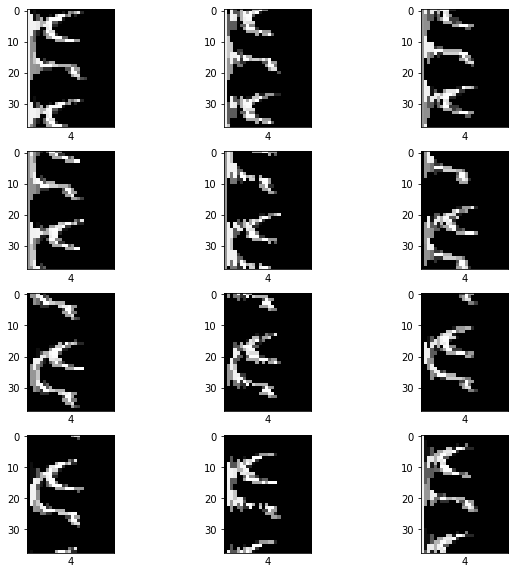

In [45]:
fig = plt.Figure(figsize=(10,10))
plt.figure(figsize=(10,10))
rows = 4
cols = 3
rad_d30 = (30/360)*(2*np.pi)
a = [i * rad_d30 for i in range(360//30)]
img_4 = np.where(train_labels == 4)[0][0]

for i in range(12):
    rot_img_4 = tfa.image.rotate(train_images[img_4], a[i]).numpy()
    #cv.imwrite(f'cat_{i}.png', (rot_img_4 * 255).astype(np.int64))
    pol_img_4 = cv.linearPolar(rot_img_4, tuple(np.array(rot_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)  
    #cv.imwrite(f'cat_polar_{i}.png', (pol_img_4 * 255).astype(np.int64))
    pol_pad_img_4 = padImage(pol_img_4, pad_sides=False)
    cv.imwrite(f'4_12samples_polNpad_{i}.png', (pol_pad_img_4 * 255).astype(np.int64))
    
    
    # Rots
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(pol_pad_img_4, cmap=plt.cm.binary_r)
    plt.xlabel(str(train_labels[img_4]))
    
plt.show()

## Computing for each class for the First Image only, the 12 times 30 to 360 deg polar image

In [46]:
rad_d30 = (30/360)*(2*np.pi)
a = [i * rad_d30 for i in range(360//30)]
class_box = []
class_preds = []
for j in range(10): 
    imgj = train_images[np.where(train_labels==j)[0][0]]
    padded_imgs = []
    for i in range(12):
        rot_img = tfa.image.rotate(imgj, a[i]).numpy()
        max_r = np.sqrt(np.sum((np.array(rot_img.shape))**2))/2
        pol_img = cv.linearPolar(rot_img, tuple(np.array(rot_img.shape)/2), max_r, cv.WARP_FILL_OUTLIERS)
        pol_pad_img = padImage(pol_img, pixels=5, pad_sides=True)
        padded_imgs.append(pol_pad_img)
    class_box.append(np.asarray(padded_imgs))
    class_preds.append(model.predict(np.expand_dims(class_box[-1], axis=-1)))
class_box = np.asarray(class_box)
class_preds = np.asarray(class_preds)

## Showing image from class 4 rotated 1*30 = 30 degrees

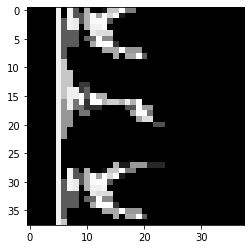

In [47]:
plt.imshow(class_box[4][1], cmap=plt.cm.binary_r)

## Predictions for the same image in the 12 rotations

In [54]:
preds = model.predict(np.expand_dims(padded_imgs, axis=-1))
np.argmax(preds,axis=1), np.std(preds[:,6])
np.argmax(class_preds[4],axis=1), np.std(preds[:,6])

(array([4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 2, 4]), 3.700799)

## Computing Euclidean dist. between the 12 rotations for the first 4 image

In [117]:
pred_4 = class_preds[4]
d_4 = np.sum((pred_4[:,None] - pred_4[None])**2, axis=-1)
d_4 = np.maximum(d_4, 0)**.5
np.sum(d_4)/12 # distance per image (12 rotations of the first 4 image)

115.12598673502605

## Computing Euclidean dist. between all images in the class 4 (randomly rotated)

In [118]:
preds_all_4 = model.predict(X_test_r_polar[np.where(test_labels == 4)])

In [119]:
d_4_all = np.sum((preds_all_4[:,None] - preds_all_4[None])**2, axis=-1)
d_4_all = np.maximum(d_4_all, 0)**.5
np.sum(d_4_all)/preds_all_4.shape[0] # distance per image (982 in class 4)

11787.739307535641

## Plotting 4 and 5 to interpret why it guess 4, when rotated 120 degrees

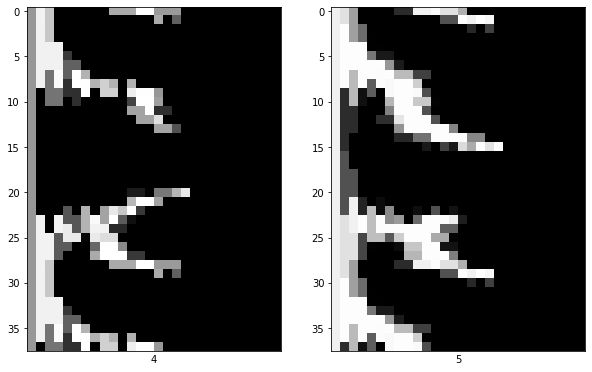

In [103]:
fig = plt.Figure(figsize=(10,10))
plt.figure(figsize=(10,10))
rows = 1
cols = 2
rad_d30 = (30/360)*(2*np.pi)
a = [i * rad_d30 for i in range(360//30)]
img_4 = np.where(train_labels == 4)[0][0]
img_5 = np.where(train_labels == 5)[0][0]

i = 4 # 120 degrees

rot_img_4 = tfa.image.rotate(train_images[img_4], a[i]).numpy()
pol_img_4 = cv.linearPolar(rot_img_4, tuple(np.array(rot_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)  
pol_pad_img_4 = padImage(pol_img_4, pad_sides=False)

rot_img_5 = tfa.image.rotate(train_images[img_5], a[0]).numpy()
pol_img_5 = cv.linearPolar(rot_img_5, tuple(np.array(rot_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)  
pol_pad_img_5 = padImage(pol_img_5, pad_sides=False)


# Rots
plt.subplot(rows,cols,1)
plt.xticks([])
plt.grid(False)
plt.imshow(pol_pad_img_4, cmap=plt.cm.binary_r)
plt.xlabel(str(train_labels[img_4]))

plt.subplot(rows,cols,2)
plt.xticks([])
plt.grid(False)
plt.imshow(pol_pad_img_5, cmap=plt.cm.binary_r)
plt.xlabel(str(train_labels[img_5]))
    
plt.show()

## Plotting 4 and 5 to interpret why it guess 4, when rotated 320 degrees

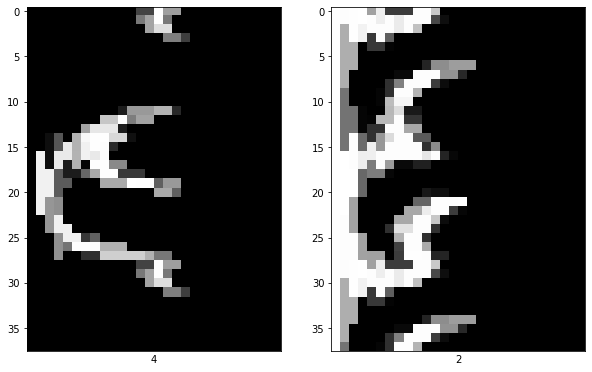

In [111]:
fig = plt.Figure(figsize=(10,10))
plt.figure(figsize=(10,10))
rows = 1
cols = 2
rad_d30 = (30/360)*(2*np.pi)
a = [i * rad_d30 for i in range(360//30)]
img_4 = np.where(train_labels == 4)[0][0]
img_2 = np.where(train_labels == 2)[0][10]

i = 8 # 320 degrees

rot_img_4 = tfa.image.rotate(train_images[img_4], a[i]).numpy()
pol_img_4 = cv.linearPolar(rot_img_4, tuple(np.array(rot_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)  
pol_pad_img_4 = padImage(pol_img_4, pad_sides=False)

rot_img_2 = tfa.image.rotate(train_images[img_2], a[0]).numpy()
pol_img_2 = cv.linearPolar(rot_img_2, tuple(np.array(rot_img_4.shape)/2), 20, cv.WARP_FILL_OUTLIERS)  
pol_pad_img_2 = padImage(pol_img_2, pad_sides=False)


# Rots
plt.subplot(rows,cols,1)
plt.xticks([])
plt.grid(False)
plt.imshow(pol_pad_img_4, cmap=plt.cm.binary_r)
plt.xlabel(str(train_labels[img_4]))

plt.subplot(rows,cols,2)
plt.xticks([])
plt.grid(False)
plt.imshow(pol_pad_img_2, cmap=plt.cm.binary_r)
plt.xlabel(str(train_labels[img_2]))
    
plt.show()